<a href="https://colab.research.google.com/github/DineshDevPandey/Pytorch_basics/blob/master/10_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchvision

In [0]:
import torch 
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms 
# torchvision contains datasets and transformations performed on these datasets

In [3]:
# MNIST images are grey scale 28x28 = 784 pixel image. each pixel value ranges from 0 to 255
# compose allows us to chain transformations togather
transform = transforms.Compose(
    [
        transforms.ToTensor(), # we need to change this numpy array to tensor, 
        # it changes np array of range 0-255 to float tensor of 0-1 range
        # which characteize images (channel, height and width)
        transforms.Normalize((0.5,), (0.5,)) 
        # first (0.5,) (corrosponding to (channel)): is mean
        # second (0.5,) (corrosponding to (channel)): is std-dev
        # we want to change out tensor range form 0-1 to -1 to 1
        # normalization helps to reduce the skewness and distortion 
    ]
    )
training_dataset = datasets.MNIST(
        root='./data',  # root dir for downloaded dataset
        train=True,     # to initilize MNIST training dataset
        download=True,  # download data
        transform=transform
    )
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# In each epoch we send all data, sending 60k images in one epoch is not good for a normal processor health
# so we use training downloader to send data in batches, 100 imagese in one epoch
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [0]:
def img_convert(tensor):
    # In order to enable automatic differentiation, PyTorch keeps track of all operations 
    # involving tensors for which the gradient may need to be computed 
    # (i.e., require_grad is True). The operations are recorded as a directed graph. 
    # The detach() method constructs a new view on a tensor which is declared not to need gradients,
    image = tensor.clone().detach().numpy()
    # each image is a grey_scale means channel=1, width=28, height=28, to plot an image we need 28x28x1 shape
    image = image.transpose(1, 2, 0) # modified axis order
    # denormalize image multiply by std and add mean
    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    # pixel value change from [-1, 1] to [0, 1]
    image = image.clip(0, 1)
    return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


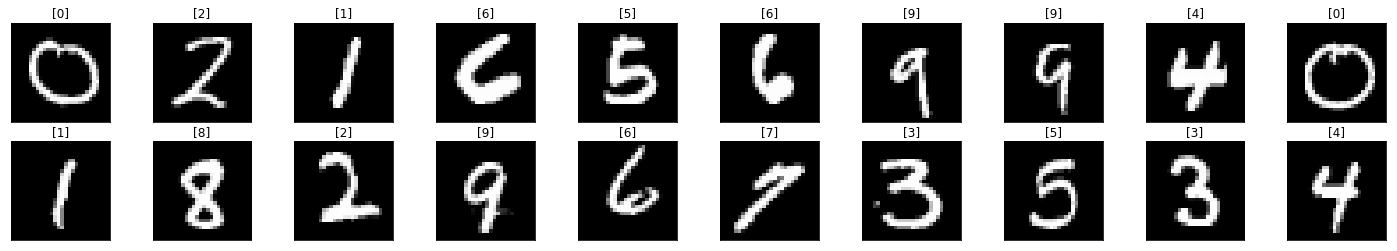

In [5]:
# To make training_loader iterable, 1 element at a time
dataiter = iter(training_loader)
# grab first batch of training data
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [0]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        # we need raw output in case of multiclass classification so not using any activation function
        x = self.linear3(x)
        return x

In [7]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
# CEL is used for loss calculation of multiclass classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [9]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:

    # each image size is 1x28x28 we need to make it one dim to feed to input layer
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # to find the total correct predictions we compare outputs and true labels.
    # softmax outputs for a input is equal to total no of classes(here 10 classes)
    # find the max one
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9200, acc 76.2300 
validation loss: 0.4226, validation acc 88.6800 
epoch : 2
training loss: 0.3759, acc 89.4100 
validation loss: 0.3169, validation acc 90.9100 
epoch : 3
training loss: 0.3131, acc 91.0867 
validation loss: 0.2871, validation acc 91.7500 
epoch : 4
training loss: 0.2777, acc 92.0233 
validation loss: 0.2571, validation acc 92.6700 
epoch : 5
training loss: 0.2517, acc 92.8167 
validation loss: 0.2324, validation acc 93.3400 
epoch : 6
training loss: 0.2298, acc 93.4200 
validation loss: 0.2151, validation acc 93.8600 
epoch : 7
training loss: 0.2114, acc 93.9767 
validation loss: 0.2052, validation acc 94.1800 
epoch : 8
training loss: 0.1958, acc 94.4033 
validation loss: 0.1872, validation acc 94.5700 
epoch : 9
training loss: 0.1816, acc 94.8550 
validation loss: 0.1739, validation acc 95.0200 
epoch : 10
training loss: 0.1694, acc 95.1233 
validation loss: 0.1744, validation acc 94.7600 
epoch : 11
training loss: 0.1584, acc 95.4717 
va

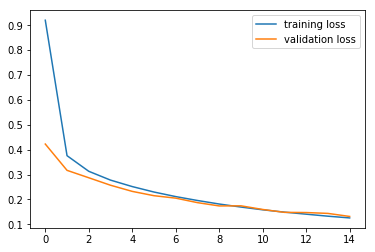

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

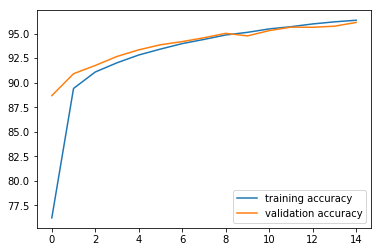

In [11]:

plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()